In [1]:
#必要モジュールのインポート
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib 
import matplotlib.pyplot as plt 
from scipy.stats import skew
from scipy.stats.stats import pearsonr 

%config InlineBackend.figure_formats = {'png', 'retina'} #matplotlib関連
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
#ファイルのダウンロード
train = pd.read_csv("TrainOfHouse.csv")
test = pd.read_csv("TestOfHouse.csv")

In [3]:
#trainデータの閲覧
#train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
#testデータの閲覧
#test.head()

In [4]:
#データの結合
#データ閲覧後のほうが範囲がわかりやすい
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [ ]:
#結合データの閲覧
#all_data

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price + 1)'}>]], dtype=object)

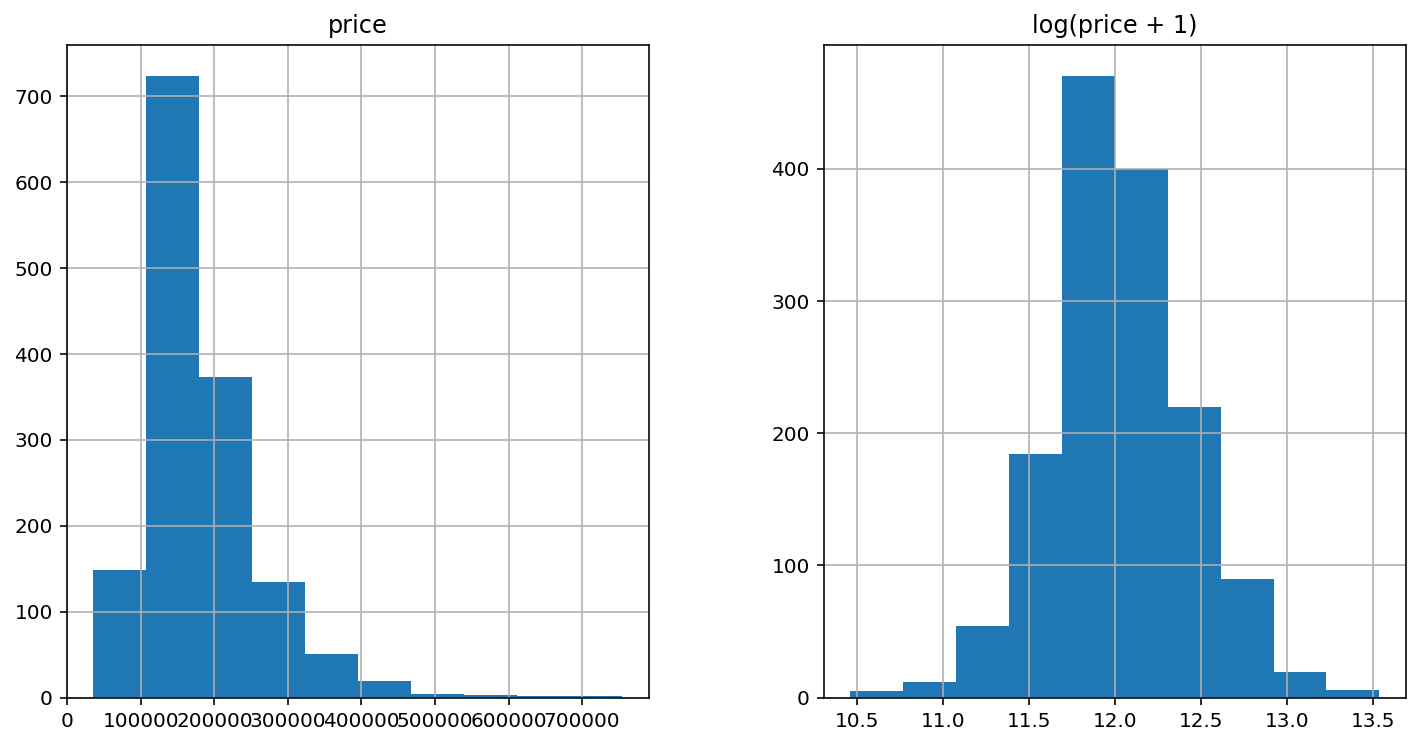

In [5]:
#グラフ化
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)  #rcParamsはmatplotlibの設定
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})  #正規化(左に偏っているから)
prices.hist()

In [6]:
train["SalePrice"] = np.log1p(train["SalePrice"])

#特徴量
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index  #objectじゃないやつ
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #skewはscipy.statsの関数、歪度(Skewness)と尖度(Kurtosis) 
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])  #正規化

In [7]:
#ダミー作成
all_data = pd.get_dummies(all_data)

In [8]:
#null値を埋める
all_data = all_data.fillna(all_data.mean())

In [ ]:
#確認用
#all_data[:train.shape[0]]
#all_data[train.shape[0]:] 

In [9]:
#分割
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:] 

In [10]:
y = train.SalePrice

In [12]:
#解析
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import RandomForestRegressor

#RMSE値の導出関数
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 10))
    return rmse

In [13]:
model_rforest = RandomForestRegressor(max_features=2)

<AxesSubplot:title={'center':'Validation'}>

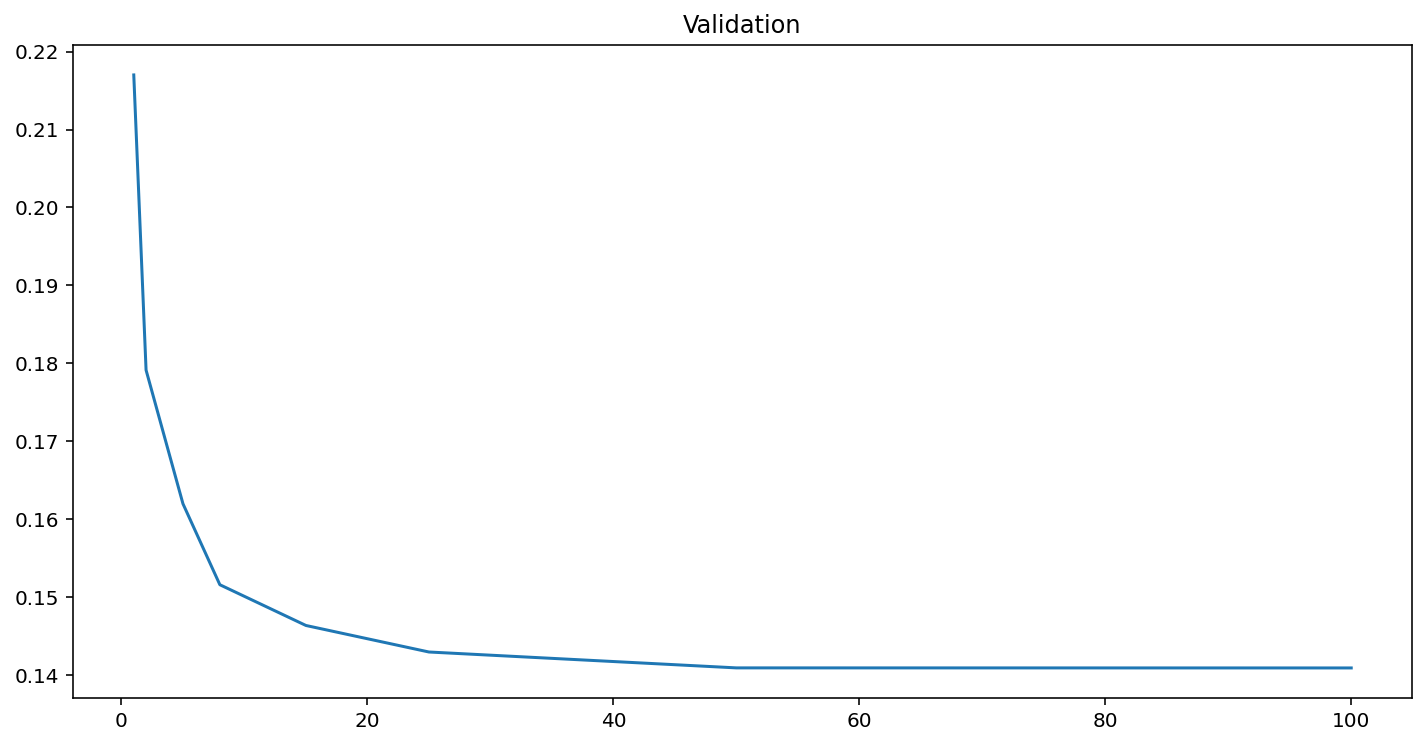

In [14]:
#解析
estimators = [1, 2, 5, 8, 15, 25, 50, 100]
cv_rforest = [rmse_cv(RandomForestRegressor(n_estimators=n).fit(X_train, y)).mean() for n in estimators]  
#バギングに用いる決定木の個数を指定
cv_rforest = pd.Series(cv_rforest, index=estimators)
cv_rforest.plot(title = "Validation")

<AxesSubplot:title={'center':'Validation'}>

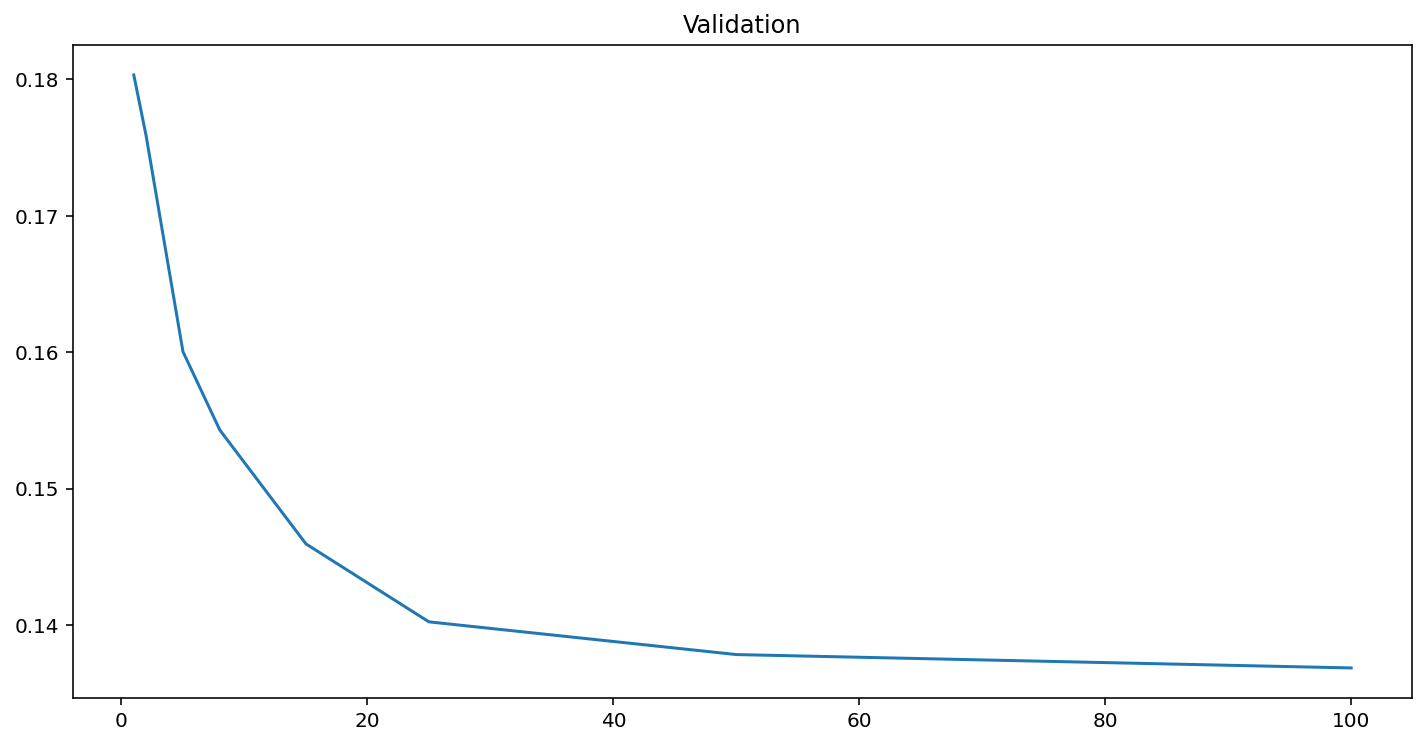

In [15]:
n_features = [1, 2, 5, 8, 15, 25, 50, 100]
cv_rforest = [rmse_cv(RandomForestRegressor(max_features=n).fit(X_train, y)).mean() for n in n_features]
#最適な分割をするために考慮するフィーチャーの数を指定
cv_rforest = pd.Series(cv_rforest, index=estimators)
cv_rforest.plot(title = "Validation")

In [16]:
model_rforest.fit(X_train, y)
model_rforest.score(X_train, y)

0.9730308518586653

In [17]:
predictions = np.expm1(model_rforest.predict(X_test)) #正規化を戻す

In [18]:
submission = pd.DataFrame({"Id":test.Id, "SalePrice": predictions})
submission.to_csv('submission.csv', index=False)

In [ ]:
#Reference
#https://www.kaggle.com/zjackwang/housing-prices-regression

In [ ]:
#score.0.17816 RSME二乗平均平方根誤差
#差を二乗して、和を取り、個数で割って、平方根を取る

In [ ]:
#住宅の項目別の特徴と価格のデータ(今回は特に数値データのみ使用)

In [ ]:
#目的は住宅の価格を予想する